In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sstats
from tqdm.auto import tqdm

In [2]:
def read_data(verbose = False):
    
    with open('ImageRawReduced.txt') as f:
        image = np.array([ list( map ( float, str.split( line.strip() ) ) ) for line in f])
        
    with open('ClassificationRules.txt') as f:
        rules = np.array([ list( map ( float, str.split( line.strip() ) ) ) for line in f])
    
    with open('ImageExpertReduced.txt') as f:
        expert = np.array([list( map ( float, str.split( line.strip() ) ) ) for line in f])
        expert = expert.ravel()
    
    if verbose:
        print('ImageRaw:\n', image)
        print('Rules:\n', rules)
        print('Expert:\n', expert)
    
    return image, rules, expert


In [3]:
def plot(arg, data, probabilities):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
    fig.suptitle(arg)
    
    ax1.set_title('Probabilities')
    ax1.plot(probabilities)
    
    ax2.set_title('Costs')
    ax2.plot(data[0], label="Top scores")
    ax2.plot(data[2], label="Mean scores")
    ax2.plot(data[1], label="Worst scores")
    ax2.legend(loc='lower right')
    
    plt.show()

In [23]:
# Pomsyl: uzycie PBIL z poprzedniego zadania
# osobnikami sa wektory 1 x 266 z wagami danej reguly
# wagi poczatkowo sa generowane z rozkladu N(0,1)
# trzymamy wektor p 1 x 266 z wartosciami oczekiwanymi u, dla losowania i-tej wagi N(u, 1)
# uczymy sie poprzez dodawanie do p[i] theta1 * x[i] - x najlepszy osobnik
# mutujemy tak samo, z tym ze p[i] = p[i] + N(0, 1) * T3
# ~65 % punktow w przedziale [u - 1, u + 1], zatem moze warto zwieszkyc T1,T3, (z malym T1,T3 ~ 0.05) powoli uczymy i mutujemy

def classified_points(x):
    
    x = np.array(x)
    # classify every point by summing wages on {1,2,3}
    predictions = []
    for i in range(rules.shape[1]):
        sum1 = sum(x[rules[:, i] == 1])
        sum2 = sum(x[rules[:, i] == 2])
        sum3 = sum(x[rules[:, i] == 3])
        
        m = max((sum1,sum2,sum3))
        if m == sum1:
            p = 1
        elif m == sum2:
            p = 2
        else:
            p = 3
            
        predictions.append(p)
    
    # return number of correct classified points
    return sum(predictions == expert)
    
def gaussian_random(p, sigma):
    # creating a gen
    return np.random.normal(loc = p, scale = sigma)

def random_population(p,N,d,sigma):
    ans = [] # population
    for i in range(N):
        #adding random individuals
        ans.append([gaussian_random(p[j], sigma) for j in range(d)])
    return ans

def evaluate_pop(pop,F):
    best_i = pop[-1]
    best_score = F(pop[-1])
    worst_score = F(pop[-1])
    mean_score = F(pop[-1])
    
    for i in range(len(pop) - 1):
        cost = F(pop[i])
        if cost > best_score:
            best_i = pop[i]
            best_score = cost
        if cost < worst_score:
            worst_score = cost
        mean_score += cost
        
    return best_i,best_score,worst_score,mean_score/len(pop)
    
def PBIL(d,F,N,T1,T2,T3,it, sigma = 0.5):
    prob = [0 for i in range(d)]
    pop = random_population(prob,N,d, sigma)
    
    #data colected every iteration
    data = np.zeros((3,it)) # matrix of [b_score, w_score, m_score]
    probabilities = []
    b_indiv = []
    
    
    for i in tqdm(range(it)):
        
        scores = evaluate_pop(pop,F)
        x = scores[0] # best individual
        probabilities.append(prob.copy())
        b_indiv.append(x.copy())
        
        '''if i % 2 == 0:
            checkpoint = (scores[1] + scores[2]) / 2
            old_checkpoint = True
            if i > 0:
                old_checkpoint = (data[0][i-1] + data[1][i - 1]) / 2 > data[2][i - 1]
            if scores[3] > checkpoint and old_checkpoint:
                sigma *= (1/0.82) # its good to search further
            else:
                sigma *= (0.82)'''
        if i % 3 == 0:
            checkpoint = True
            if i > 0:
                checkpoint = scores[1] > data[0][i - 1] and scores[1] > data[0][i - 2]
            if checkpoint:
                sigma *= (1/0.82) # its good to search further
            else:
                sigma *= (0.82)
            if i % 15 == 0:
                print(f'{i} iteration, best score: {scores[1] / len(expert) * 100.0:.4f}%, sigma = {sigma}')
                
        #save data from evaluating population
        for j in range(len(scores) - 1):
            data[j][i] = scores[j + 1]
            
        for k in range(d):
            #learning
            prob[k] = prob[k] + x[k] * T1
        for k in range(d):
            #mutating
            if random.uniform(0,1) < T2:
                prob[k] = prob[k] + np.random.normal(loc = prob[k], scale = sigma) * T3
        pop = random_population(prob,N,d, sigma)
        
    return data, probabilities, b_indiv
        

In [5]:
image, rules, expert = read_data(verbose = True)

ImageRaw:
 [[26. 29. 33. ... 34. 31. 41.]
 [16. 23. 24. ... 22. 26. 30.]
 [75. 68. 86. ... 20. 25. 23.]]
Rules:
 [[1. 1. 1. ... 1. 1. 3.]
 [1. 1. 1. ... 3. 3. 3.]
 [1. 1. 1. ... 2. 2. 2.]
 ...
 [3. 3. 3. ... 3. 3. 3.]
 [3. 3. 3. ... 3. 3. 3.]
 [3. 3. 3. ... 3. 3. 3.]]
Expert:
 [1. 1. 1. ... 3. 3. 3.]


In [10]:
a = [266, classified_points, 30, 0.2, 0.05, 0.1, 70, "classified_points"]
data, probabilities, b_indiv = PBIL(*a[:-1])

At most 8989.0 correct classified points in 23 iteration which is 96.1390% accuracy
Best rules to take:
 []


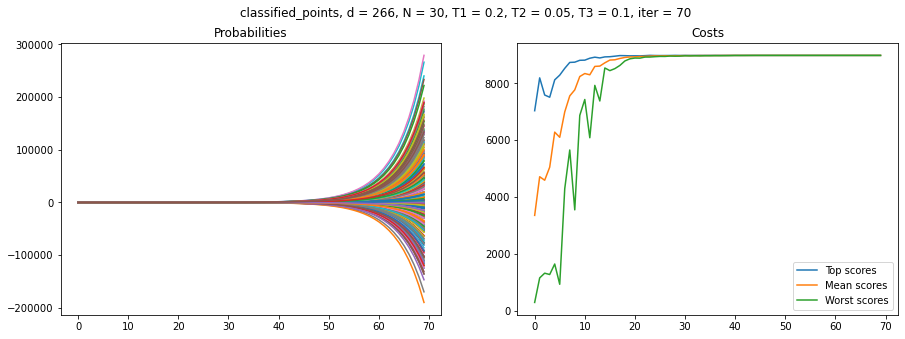

In [11]:
#prob[k] = prob[k] + np.random.normal() * T3 mutacje
#return np.random.normal(loc = p) losowanie genu
d,func,N,T1,T2,T3,it,name = a
arg = f'{name}, d = {d}, N = {N}, T1 = {T1}, T2 = {T2}, T3 = {T3}, iter = {it}'

scores = np.array(data[0])
best_s = np.argmax(scores)

print(f'At most {scores[best_s]} correct classified points \
in {best_s} iteration which is {scores[best_s] / len(expert) * 100.0:.4f}% accuracy')

best_rules = np.array(b_indiv[best_s])
b_r = np.arange(266)[best_rules == 1]
print(f'Best rules to take:\n {b_r}')

plot(arg, data, probabilities)

In [13]:
# calkiem dobrze to wyszlo, przy działaniu 19min -  w porownaniu do 3h uzyskało niewiele gorsza accuracy
# troche szybko przykleja sie do maximum, moze wieksze mutacje a mniej uczenia
# problem - bierzemy zawsze 0.09 * u, a u moze urosnac do 300k i sie inaczej skaluje moze zmniejszyc wariancje?
# po pewnym czasie mutacja z t3 * N(0,1) moze byc zadna w porownaniu do par uczenia sie
# prob[k] = prob[k] + np.random.normal(loc = prob[k]) * T3 skalujmy tez mutacje - pomysl na zmniejszenie T3 wzgeldem T1

In [14]:
a1 = [266, classified_points, 30, 0.1, 0.1, 0.04, 70, "classified_points"]
data1, probabilities1, b_indiv1 = PBIL(*a[:-1])

At most 8695.0 correct classified points in 33 iteration which is 92.9947% accuracy
Best rules to take:
 []


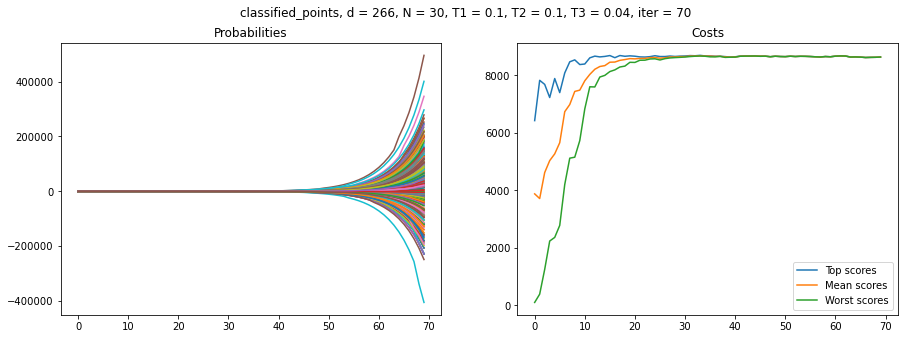

In [15]:
d,func,N,T1,T2,T3,it,name = a1
arg1 = f'{name}, d = {d}, N = {N}, T1 = {T1}, T2 = {T2}, T3 = {T3}, iter = {it}'

scores = np.array(data1[0])
best_s = np.argmax(scores)

print(f'At most {scores[best_s]} correct classified points \
in {best_s} iteration which is {scores[best_s] / len(expert) * 100.0:.4f}% accuracy')

best_rules = np.array(b_indiv1[best_s])
b_r = np.arange(266)[best_rules == 1]
print(f'Best rules to take:\n {b_r}')

plot(arg1, data1, probabilities1)

In [20]:
a2 = [266, classified_points, 50, 0.2, 0.05, 0.1, 200, "classified_points"]
data2, probabilities2, b_indiv2 = PBIL(*a2[:-1])

At most 9125.0 correct classified points in 79 iteration which is 97.5936% accuracy
Best rules to take:
 []


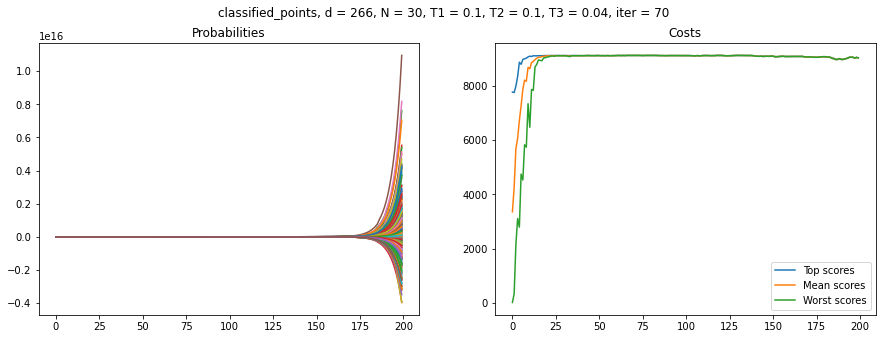

In [21]:
d,func,N,T1,T2,T3,it,name = a2
arg2 = f'{name}, d = {d}, N = {N}, T1 = {T1}, T2 = {T2}, T3 = {T3}, iter = {it}'

scores = np.array(data2[0])
best_s = np.argmax(scores)

print(f'At most {scores[best_s]} correct classified points \
in {best_s} iteration which is {scores[best_s] / len(expert) * 100.0:.4f}% accuracy')

best_rules = np.array(b_indiv2[best_s])
b_r = np.arange(266)[best_rules == 1]
print(f'Best rules to take:\n {b_r}')

plot(arg2, data2, probabilities2)

In [15]:
a3 = [266, classified_points, 20, 0.2, 0.05, 0.1, 60, "classified_points"]
data3, probabilities3, b_indiv3 = PBIL(*a3[:-1])

0 iteration, best score: 77.8503%, sigma = 0.41
2 iteration, best score: 78.7914%, sigma = 0.49999999999999994
4 iteration, best score: 78.2353%, sigma = 0.6097560975609755
6 iteration, best score: 82.5455%, sigma = 0.7436049970255798
8 iteration, best score: 90.3209%, sigma = 0.9068353622263168
10 iteration, best score: 94.0749%, sigma = 1.1058967832028253
12 iteration, best score: 93.9037%, sigma = 1.348654613661982
14 iteration, best score: 94.5348%, sigma = 1.6447007483682705
16 iteration, best score: 94.4385%, sigma = 2.0057326199613055
18 iteration, best score: 95.2193%, sigma = 2.446015390196714
20 iteration, best score: 95.9465%, sigma = 2.982945597800871
22 iteration, best score: 96.0214%, sigma = 3.637738533903501
24 iteration, best score: 96.7380%, sigma = 4.436266504760367
26 iteration, best score: 96.7487%, sigma = 5.4100811033663
28 iteration, best score: 96.9626%, sigma = 6.597659882154025
30 iteration, best score: 97.0374%, sigma = 8.045926685553688
32 iteration, best s

KeyboardInterrupt: 

In [16]:
a4 = [266, classified_points, 20, 0.2, 0.05, 0.1, 60, "classified_points"]
data4, probabilities4, b_indiv4 = PBIL(*a4[:-1])

0 iteration, best score: 76.4278%, sigma = 0.41
2 iteration, best score: 85.9679%, sigma = 0.49999999999999994
4 iteration, best score: 84.7594%, sigma = 0.4099999999999999
6 iteration, best score: 82.5882%, sigma = 0.4999999999999999
8 iteration, best score: 88.9198%, sigma = 0.6097560975609755
10 iteration, best score: 90.2888%, sigma = 0.7436049970255798
12 iteration, best score: 92.6417%, sigma = 0.9068353622263168
14 iteration, best score: 92.7701%, sigma = 1.1058967832028253
16 iteration, best score: 95.1979%, sigma = 0.9068353622263167
18 iteration, best score: 94.5027%, sigma = 1.1058967832028253
20 iteration, best score: 95.3262%, sigma = 1.348654613661982
22 iteration, best score: 95.7861%, sigma = 1.6447007483682705
24 iteration, best score: 95.4439%, sigma = 2.0057326199613055
26 iteration, best score: 95.5936%, sigma = 2.446015390196714
28 iteration, best score: 95.8610%, sigma = 2.982945597800871
30 iteration, best score: 95.9251%, sigma = 3.637738533903501
32 iteration, 

KeyboardInterrupt: 

In [27]:
a5 = [266, classified_points, 80, 0.3, 0.05, 0.1, 60, "classified_points"]
data5, probabilities5, b_indiv5 = PBIL(*a5[:-1], sigma = 0.4)

0 iteration, best score: 82.5455%, sigma = 0.4878048780487805
15 iteration, best score: 97.5936%, sigma = 1.3157605986946168
30 iteration, best score: 97.5829%, sigma = 1.6045860959690443
45 iteration, best score: 97.5508%, sigma = 0.8847174265622598



At most 9130.0 correct classified points in 25 iteration which is 97.6471% accuracy
Best rules to take:
 []


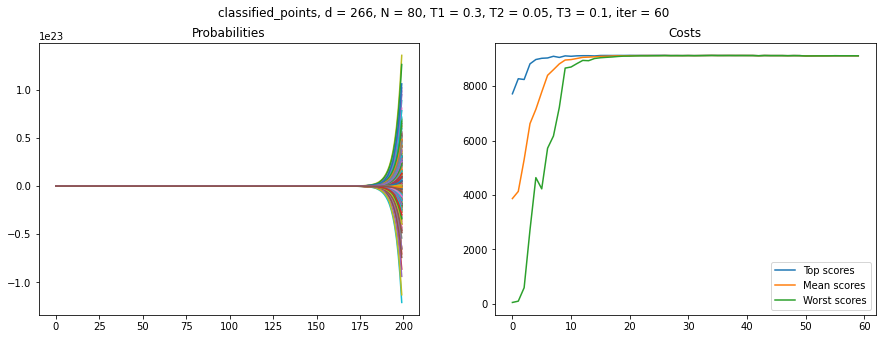

In [28]:
d,func,N,T1,T2,T3,it,name = a5
arg5 = f'{name}, d = {d}, N = {N}, T1 = {T1}, T2 = {T2}, T3 = {T3}, iter = {it}'

scores = np.array(data5[0])
best_s = np.argmax(scores)

print(f'At most {scores[best_s]} correct classified points \
in {best_s} iteration which is {scores[best_s] / len(expert) * 100.0:.4f}% accuracy')

best_rules = np.array(b_indiv5[best_s])
b_r = np.arange(266)[best_rules == 1]
print(f'Best rules to take:\n {b_r}')

plot(arg5, data5, probabilities6)

In [24]:
a6 = [266, classified_points, 80, 0.3, 0.07, 0.1, 200, "classified_points"]
data6, probabilities6, b_indiv6 = PBIL(*a6[:-1], sigma = 0.4)

0 iteration, best score: 83.0053%, sigma = 0.4878048780487805
15 iteration, best score: 96.7914%, sigma = 0.594883997620464
30 iteration, best score: 96.8235%, sigma = 0.4878048780487804
45 iteration, best score: 96.6096%, sigma = 0.26895999999999987
60 iteration, best score: 96.2246%, sigma = 0.22054719999999986
75 iteration, best score: 95.3155%, sigma = 0.12160266856959989
90 iteration, best score: 95.7861%, sigma = 0.14829593727999987
105 iteration, best score: 94.3102%, sigma = 0.12160266856959989
120 iteration, best score: 92.1283%, sigma = 0.045082954278195024
135 iteration, best score: 92.5989%, sigma = 0.024857298334459824
150 iteration, best score: 93.1551%, sigma = 0.01370551886807444
165 iteration, best score: 92.1604%, sigma = 0.005081181916124559
180 iteration, best score: 92.7166%, sigma = 0.006196563312347023
195 iteration, best score: 92.8342%, sigma = 0.005081181916124558



At most 9059.0 correct classified points in 28 iteration which is 96.8877% accuracy
Best rules to take:
 []


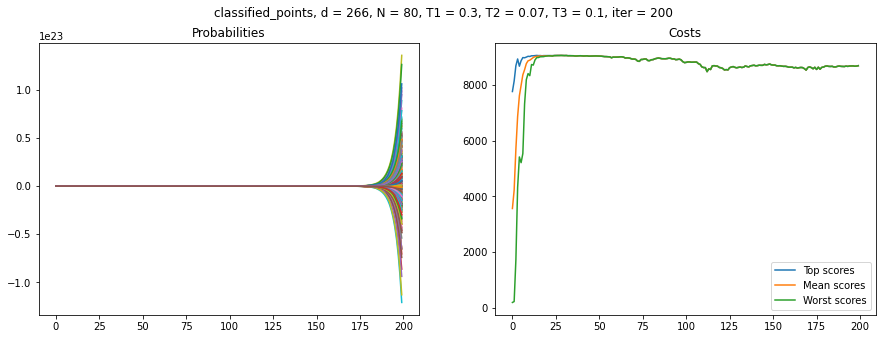

In [26]:
d,func,N,T1,T2,T3,it,name = a6
arg6 = f'{name}, d = {d}, N = {N}, T1 = {T1}, T2 = {T2}, T3 = {T3}, iter = {it}'

scores = np.array(data6[0])
best_s = np.argmax(scores)

print(f'At most {scores[best_s]} correct classified points \
in {best_s} iteration which is {scores[best_s] / len(expert) * 100.0:.4f}% accuracy')

best_rules = np.array(b_indiv6[best_s])
b_r = np.arange(266)[best_rules == 1]
print(f'Best rules to take:\n {b_r}')

plot(arg6, data6, probabilities6)